<a href="https://colab.research.google.com/github/kregier/AudioLanguageClassifer/blob/main/DataWranglingEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Language classsifier
Identify the gender and/or native language of speakers reading a fixed passage in English.

The goal is to use the pre-trained vggish model to extract features from audio files, and train a classifier to identify the gender and/or native language or the speaker.

The data is a subset of the Speech Accent Archive, available from https://www.kaggle.com/rtatman/speech-accent-archive

In [118]:
# Set up the environment
!pip install pyAudioAnalysis
!pip install hmmlearn
!pip install eyed3
!pip install pydub
!pip install soundfile

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import IPython.display as ipd
import librosa
import librosa.display

from pyAudioAnalysis import audioSegmentation as aS

import os
import random

import tensorflow as tf
import tensorflow_hub as hub

In [77]:
# Load the vggish model from the TF hub
model = hub.load('https://tfhub.dev/google/vggish/1')

# Data wrangling
## Load the data and metadata

In [78]:
# Set up the data import using Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [79]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

# Change working directory
%cd /content/gdrive/My Drive/Kaggle
!ls

/content/gdrive/My Drive/Kaggle
kaggle.json  reading-passage.txt  recordings  speakers_all.csv


In [80]:
# Copy Kaggle API command - only needs to be done the first time
#!kaggle datasets download -d rtatman/speech-accent-archive

In [81]:
!ls

kaggle.json  reading-passage.txt  recordings  speakers_all.csv


In [82]:
# unzip the zip files and remove the zip files - only needs to be done the first time
#!unzip \*.zip && rm *.zip

In [83]:
text = pd.read_csv('reading-passage.txt', header=None, delimiter='.')
text.head().T

,0
0,Please call Stella
1,Ask her to bring these things with her from ...
2,We also need a small plastic snake and a big...
3,She can scoop these things into three red ba...
4,NaN


In [84]:
meta = pd.read_csv('speakers_all.csv')
meta.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True,NaN,NaN,NaN
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True,NaN,NaN,NaN
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True,NaN,NaN,NaN
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True,NaN,NaN,NaN
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True,NaN,NaN,NaN


In [85]:
# Drop 3 end columns with NaN values
meta.drop(['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'], axis=1, inplace=True)

# Set speakerid as index
meta.set_index('speakerid', inplace=True)
meta.sort_index(inplace=True)
meta.head()

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
1,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,south africa,False
2,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,south africa,False
3,25.0,15.0,"diekabo, ivory coast",agni1,agni,male,ivory coast,False
4,19.0,6.0,"prishtina, kosovo",albanian1,albanian,male,kosovo,False
5,33.0,15.0,"tirana, albania",albanian2,albanian,male,albania,False


## EDA
- How many speakers per native language?
- What are the top languages present in the database?
- What is the distribution of speakers by gender and language?
- How many dialects of English are represented? (native_language == English, by birthplace and country values)


In [86]:
# How many unique values are there per column?
meta.nunique()

age                  80
age_onset            59
birthplace         1290
filename           2156
native_language     214
sex                   3
country             176
file_missing?         2
dtype: int64

In [87]:
# How many columns have null values?
meta.isnull().sum()

age                0
age_onset          0
birthplace         4
filename           0
native_language    0
sex                0
country            5
file_missing?      0
dtype: int64

In [88]:
meta.loc[meta.birthplace.isnull()]

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
355,0.0,0.0,NaN,synthesized1,synthesized,male,NaN,False
356,0.0,0.0,NaN,synthesized2,synthesized,female,NaN,False
357,0.0,0.0,NaN,synthesized3,synthesized,female,NaN,False
358,0.0,0.0,NaN,synthesized4,synthesized,male,NaN,False


In [89]:
meta.loc[meta.country.isnull()]

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
249,25.0,21.0,"vientiane, laos,",lao2,lao,female,NaN,False
355,0.0,0.0,NaN,synthesized1,synthesized,male,NaN,False
356,0.0,0.0,NaN,synthesized2,synthesized,female,NaN,False
357,0.0,0.0,NaN,synthesized3,synthesized,female,NaN,False
358,0.0,0.0,NaN,synthesized4,synthesized,male,NaN,False


It makes sense that the synthesized audio files would not have birthplace or country information, since a synthesized voice would not have a birthplace or country.
Since I want to train the model on real voices, I will delete the synthesized voices from the data.

In [90]:
meta.dropna(subset=['birthplace'], inplace=True)
meta.loc[meta.native_language=='lao']

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
248,19.0,12.0,"savannakhet, laos",lao1,lao,female,laos,False
249,25.0,21.0,"vientiane, laos,",lao2,lao,female,NaN,False
2007,52.0,20.0,"pakxe, laos",lao3,lao,male,laos,False


The remaining missing value is in the country column from one Lao speaker. Since the other two Lao speakers have Laos as their country, I will impute Laos as the country value for the remaining speaker as well.

In [91]:
meta.country.loc[meta.country.isnull()] = 'laos'
print(meta.loc[249, :])
meta.isnull().sum()

age                               25
age_onset                         21
birthplace         vientiane, laos, 
filename                        lao2
native_language                  lao
sex                           female
country                         laos
file_missing?                  False
Name: 249, dtype: object


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


age                0
age_onset          0
birthplace         0
filename           0
native_language    0
sex                0
country            0
file_missing?      0
dtype: int64

### How many speakers per native language?

In [92]:
# Hard to see the scope because there are so many with only one speaker
meta.native_language.value_counts()

english     579
spanish     162
arabic      102
mandarin     65
french       63
           ... 
rwanda        1
cebuano       1
naxi          1
nandi         1
yapese        1
Name: native_language, Length: 213, dtype: int64

In [93]:
# How many native languages, total?
meta.native_language.nunique()

213

In [94]:
# How many native languages with only one speaker in the database?
meta.native_language.value_counts().loc[meta.native_language.value_counts() == 1]

carolinian     1
mortlockese    1
akan           1
konkani        1
shan           1
              ..
rwanda         1
cebuano        1
naxi           1
nandi          1
yapese         1
Name: native_language, Length: 85, dtype: int64

There are 85 native languages represented by only one speaker in the database. This means there are 128 languages represented by 2 or more speakers.

### What are the top 10 languages in the data, in addition to English?

In [95]:
lang_counts = meta.native_language.value_counts().head(11)
lang_counts

english       579
spanish       162
arabic        102
mandarin       65
french         63
korean         52
portuguese     48
russian        48
dutch          47
turkish        37
german         36
Name: native_language, dtype: int64

In [96]:
lang_list = ['spanish', 'arabic', 'mandarin', 'french', 'korean', 'russian', 
             'portuguese', 'dutch', 'turkish', 'german']
top_lang = meta.loc[meta.native_language.isin(lang_list)]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

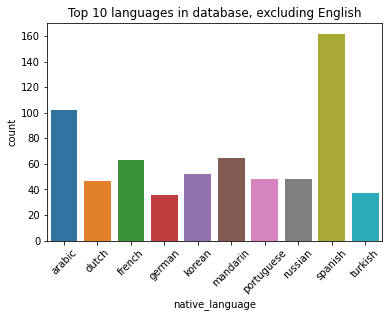

In [97]:
sns.countplot(x='native_language', data=top_lang)
plt.title('Top 10 languages in database, excluding English')
plt.xticks(rotation=45)

### What is the distribution of speakers by gender?

In [98]:
meta.loc[meta.loc[:,'sex']=='famale'] = 'female'
meta.sex.value_counts()

male      1121
female    1047
Name: sex, dtype: int64

Text(0.5, 1.0, 'Distibution of speakers by gender - Whole database')

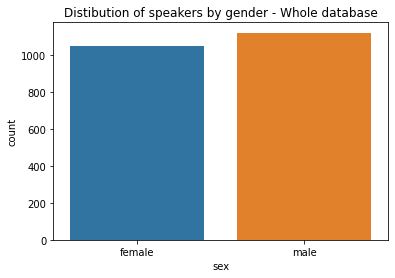

In [99]:
sns.countplot(x='sex', data=meta)
plt.title('Distibution of speakers by gender - Whole database')

Text(0.5, 1.0, 'Distribution of speakers by gender - Top languages')

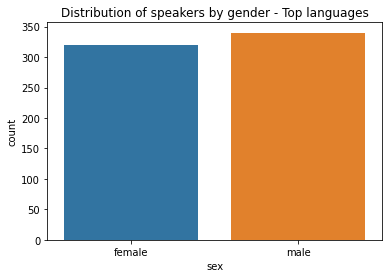

In [100]:
sns.countplot(x='sex', data=top_lang)
plt.title('Distribution of speakers by gender - Top languages')

### How many varieties of (native) Engish are represented in the database?
While we don't know which varieity of English the native speakers use, we can infer the variety by looking at their birthplace and country.

In [101]:
# How many varieties of English are represented in the database?
english = meta.loc[meta.native_language == 'english']
english.country.value_counts()

usa                     373
uk                       65
canada                   44
australia                32
ireland                  11
new zealand               8
jamaica                   5
singapore                 4
south africa              4
panama                    3
india                     3
philippines               2
guyana                    2
malaysia                  2
virginia                  1
bolivia                   1
nigeria                   1
the bahamas               1
fiji                      1
antigua and barbuda       1
pakistan                  1
papua new guinea          1
switzerland               1
isle of man               1
belize                    1
germany                   1
spain                     1
liberia                   1
trinidad                  1
lebanon                   1
us virgin islands         1
united arab emirates      1
barbados                  1
italy                     1
ghana                     1
Name: country, dtype

Text(0.5, 1.0, 'Native English speakers by country')

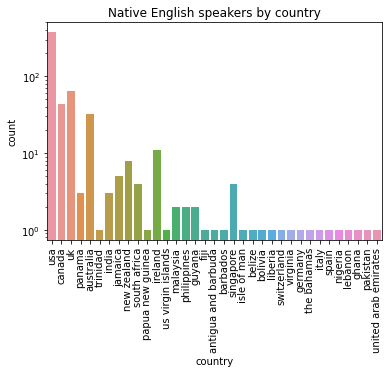

In [102]:
sns.countplot(x='country', data=english)
plt.yscale('log')
plt.xticks(rotation=90)
plt.title('Native English speakers by country')

In [103]:
english.birthplace.value_counts()

sydney, australia                        8
washington, district of columbia, usa    7
toronto, ontario, canada                 7
dublin, ireland                          6
boston, massachusetts, usa               6
                                        ..
christchurch, new zealand                1
southhampton, uk                         1
plymouth, massachusetts, usa             1
palmer, alaska, usa                      1
oamaru, new zealand                      1
Name: birthplace, Length: 421, dtype: int64

In [104]:
english.birthplace.str.contains('usa').sum()

373

In [105]:
english.birthplace.str.contains('uk').sum()

67

In [106]:
english.birthplace.str.contains('canada').sum()

44

In [107]:
english.birthplace.str.contains('australia').sum()

32

The birthplace column is a bit hard to parse for country, since the column entries include cities, optional provinces/states, and country. However, the number of speakers from each country by birthplace seem to correspond to a high degree, when the birthplace column is filtered for the top 4 "countries".

## Audio Files
Since the speakers read a fixed English passage with 4 sentences, I expect that the resulting audio files are going to be fairly long.

Also, the files are in the .mp3 format, so I'm not sure what sampling rate is standard.

In [108]:
# Load a sample audio file - play the audio file and look at the waveform
# Choose a random sound file to examine
idx = random.choice(meta.filename)
filepath = 'recordings/recordings/' + idx + '.mp3'
print(filepath)

recordings/recordings/vlaams2.mp3


In [109]:
ipd.Audio(filepath)

In [110]:
# Librosa default mixed at mono, resampled to 22050 Hz
# Vggish was trained on audio at 16 kHz
SAMP_RATE = 16000
y, sr = librosa.load(filepath, sr=SAMP_RATE)

Text(0.5, 1.0, 'Waveform of audio file')

<Figure size 1080x216 with 0 Axes>

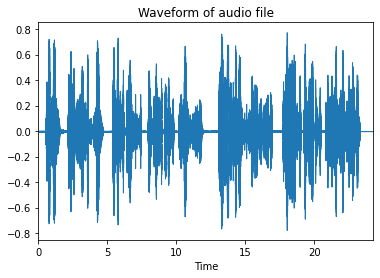

In [111]:
plt.figure(figsize=(15, 3))
plt.figure()
librosa.display.waveplot(y, sr=sr)
plt.title('Waveform of audio file')

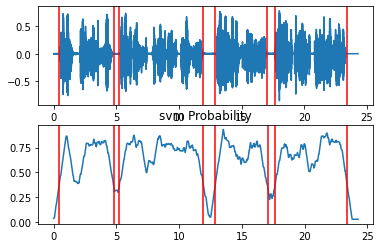

In [121]:
# https://github.com/tyiannak/pyAudioAnalysis/wiki/5.-Segmentation

# segments is a list of endpoints
segments = aS.silence_removal(y, SAMP_RATE, 0.020, 0.020, smooth_window = 1.0, weight = 0.3, plot = True)

In [122]:
print(segments)

[[0.44, 4.78], [5.22, 11.94], [12.88, 17.06], [17.64, 23.400000000000002]]


In [126]:
print(y[0:100])

[0.00046145 0.00082807 0.00071298 0.00070191 0.00062348 0.00048194
 0.00027835 0.00061805 0.00057344 0.00090432 0.00086734 0.00046969
 0.00047184 0.00060101 0.00086799 0.00061047 0.00074138 0.00056492
 0.00031485 0.00068955 0.00096384 0.00094315 0.00093202 0.0010871
 0.00131699 0.00126516 0.00116491 0.0014465  0.00154401 0.00137695
 0.0011689  0.00096918 0.00133828 0.00148933 0.00144743 0.00157577
 0.00141821 0.00132819 0.00141324 0.00166925 0.00133979 0.00121531
 0.0012879  0.00132587 0.0012814  0.00120137 0.00157304 0.00171783
 0.00176359 0.00174559 0.00149637 0.00133935 0.00167209 0.00162376
 0.00158748 0.00172917 0.00172941 0.0018074  0.00170291 0.00173661
 0.00191658 0.00180265 0.00171454 0.00172583 0.00170401 0.001637
 0.00158209 0.00197267 0.00163891 0.00169875 0.00183904 0.00171169
 0.00183158 0.00165717 0.00162613 0.00162978 0.00162775 0.00143289
 0.00158717 0.00144565 0.00145531 0.00142638 0.00134974 0.00145124
 0.00134615 0.00149475 0.00131103 0.00133721 0.00140863 0.0013712

In [138]:
def get_segments(audio, samp_rate):
  segments = aS.silence_removal(audio, samp_rate, 0.020, 0.020, smooth_window = 1.0, weight = 0.3, plot = False)
  seg_files = {}
  for idx, seg in enumerate(segments):
    beg = int(seg[0] * samp_rate)
    ending = int(seg[1] * samp_rate)
    new_audio = audio[beg:ending]
    seg_files[idx] = new_audio
  return seg_files

seg_audio = get_segments(y, SAMP_RATE)

In [148]:
# Cycle through segmented files and write each one to a new file with dynamic names
#!pip install soundfile
#import soundfile as sf
for key, val in seg_audio.items():
  new_name = idx + "." + str(key)
  filepath = 'recordings/recordings/' + new_name + '.wav'
  sf.write(filepath, val, samplerate=SAMP_RATE)

# Data Augmentation
- Break paragraph into sentences by dividing at pauses
- Add random noise (at varying levels) to the files
- Possible pitch manipulation

Each speaker read the same paragraph in English. The script contained 4 sentences, which results in a fairly long audio file. 

In [ ]:
# Extract mfcc
# HOP = 10
# mfcc = librosa.feature.mfcc(y=y, sr=SAMP_RATE, hop_length=HOP, n_mfcc=13)

VGGish input is : 96x64 for log mel spectrogram audio inputs

From VGGish documentation
VGGish was trained with audio features computed as follows:

- All audio is resampled to 16 kHz mono.
- A spectrogram is computed using magnitudes of the Short-Time Fourier Transform with a window size of 25 ms, a window hop of 10 ms, and a periodic Hann window.
- A mel spectrogram is computed by mapping the spectrogram to 64 mel bins covering the range 125-7500 Hz.
- A stabilized log mel spectrogram is computed by applying log(mel-spectrum + 0.01) where the offset is used to avoid taking a logarithm of zero.
- These features are then framed into non-overlapping examples of 0.96 seconds, where each example covers 64 mel bands and 96 frames of 10 ms each.

VGGish has code for converting audio to input - I could use that, or write my own.


# Gender classifier
- binary options: logistic regression, sigmoid function?

# Build a model
- Feature extraction from vggish
- Gender classifier layers

# Train the model

# Evaluate the results